In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import joblib

In [3]:
# =========================
# 1) LOAD DATA + EDA SINGKAT
# =========================
DATA_PATH = "UCI_Credit_Card.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
df.info()
display(df.describe(include="all").T.head(30))

target_col = "default.payment.next.month"
assert target_col in df.columns, f"Kolom target '{target_col}' tidak ditemukan."

print("\nMissing values per column:")
display(df.isna().sum())

print("\nTarget distribution:")
display(df[target_col].value_counts())
display(df[target_col].value_counts(normalize=True))

# Drop ID (tidak informatif)
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# Cleaning kategori anomali (baik untuk dataset ini)
if "EDUCATION" in df.columns:
    df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})
if "MARRIAGE" in df.columns:
    df["MARRIAGE"]  = df["MARRIAGE"].replace({0: 3})

Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0



Missing values per column:


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


Target distribution:


default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [4]:
# =====================================
# 2) LABEL ENCODING TARGET BINER
# =====================================
y_raw = df[target_col]
X_raw = df.drop(columns=[target_col])

le = LabelEncoder()
y = le.fit_transform(y_raw)

In [5]:
# ==========================================
# 3) SPLIT DATA: TRAIN / VALIDATION / TEST
# ==========================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X_raw, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# >>> TAMBAHAN: copy() agar tidak muncul SettingWithCopyWarning
X_train = X_train.copy()
X_val   = X_val.copy()
X_test  = X_test.copy()

print("\nSplit shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Split shapes:
Train: (21000, 23) (21000,)
Val  : (4500, 23) (4500,)
Test : (4500, 23) (4500,)


In [6]:
# ==========================================
# 4) DATA PREPROCESSING
# ==========================================
categorical_cols = [c for c in ["SEX", "EDUCATION", "MARRIAGE"] if c in X_raw.columns]
numeric_cols = [c for c in X_raw.columns if c not in categorical_cols]

# ---- Imputasi ----
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

if len(categorical_cols) > 0:
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_val[categorical_cols]   = cat_imputer.transform(X_val[categorical_cols])
    X_test[categorical_cols]  = cat_imputer.transform(X_test[categorical_cols])

X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_val[numeric_cols]   = num_imputer.transform(X_val[numeric_cols])
X_test[numeric_cols]  = num_imputer.transform(X_test[numeric_cols])

# ---- Pastikan tipe kategori konsisten (int) ----
for c in categorical_cols:
    X_train[c] = X_train[c].astype(int)
    X_val[c]   = X_val[c].astype(int)
    X_test[c]  = X_test[c].astype(int)

# ---- One-Hot Encoding ----
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_val   = pd.get_dummies(X_val,   columns=categorical_cols, drop_first=False)
X_test  = pd.get_dummies(X_test,  columns=categorical_cols, drop_first=False)

# Samakan kolom agar konsisten dengan train
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# >>> PENTING untuk deploy: simpan nama kolom setelah one-hot (SEBELUM jadi numpy)
feature_columns = X_train.columns.tolist()

# ---- Scaling ----
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# >>> Pastikan tidak ada NaN sesuai instruksi
print("\nNaN check after preprocessing:")
print("Train NaN:", np.isnan(X_train).sum())
print("Val NaN  :", np.isnan(X_val).sum())
print("Test NaN :", np.isnan(X_test).sum())

input_dim = X_train.shape[1]
print("\nInput dim:", input_dim)



NaN check after preprocessing:
Train NaN: 0
Val NaN  : 0
Test NaN : 0

Input dim: 29


In [7]:
# ==========================================
# 5) PEMBANGUNAN MODEL ANN
# ==========================================
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1920      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4033 (15.75 KB)
Trainable params: 4033 (15.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# ==========================================
# 6) COMPILE MODEL
# ==========================================
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# ==========================================
# 7) TRAINING MODEL
# ==========================================
EPOCHS = 80
BATCH_SIZE = 256

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/80


83/83 [==============================] - 3s 8ms/step - loss: 0.5087 - accuracy: 0.7856 - val_loss: 0.4775 - val_accuracy: 0.8011
Epoch 2/80
83/83 [==============================] - 0s 4ms/step - loss: 0.4598 - accuracy: 0.8145 - val_loss: 0.4588 - val_accuracy: 0.8098
Epoch 3/80
83/83 [==============================] - 0s 4ms/step - loss: 0.4476 - accuracy: 0.8167 - val_loss: 0.4526 - val_accuracy: 0.8091
Epoch 4/80
83/83 [==============================] - 0s 3ms/step - loss: 0.4420 - accuracy: 0.8195 - val_loss: 0.4463 - val_accuracy: 0.8142
Epoch 5/80
83/83 [==============================] - 0s 3ms/step - loss: 0.4383 - accuracy: 0.8207 - val_loss: 0.4445 - val_accuracy: 0.8138
Epoch 6/80
83/83 [==============================] - 0s 4ms/step - loss: 0.4357 - accuracy: 0.8216 - val_loss: 0.4490 - val_accuracy: 0.8142
Epoch 7/80
83/83 [==============================] - 0s 4ms/step - loss: 0.4348 - accuracy: 0.8216 - val_loss: 0.4419 - val_accuracy: 0.8164
Epoch 8/80
83/83 [

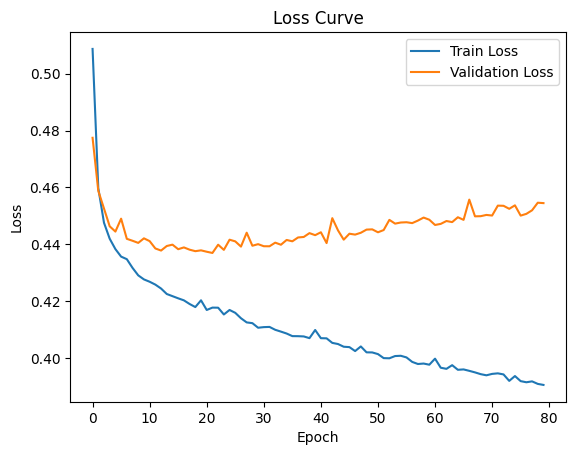

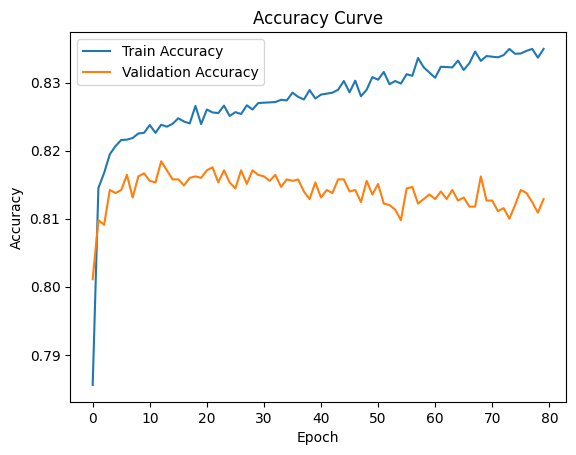

In [10]:
# ==========================================
# 8) VISUALISASI LEARNING CURVE
# ==========================================
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

141/141 [==============================] - 0s 2ms/step

Accuracy: 0.8102222222222222
F1-score: 0.47022332506203474

Confusion Matrix:
[[3267  237]
 [ 617  379]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8411    0.9324    0.8844      3504
           1     0.6153    0.3805    0.4702       996

    accuracy                         0.8102      4500
   macro avg     0.7282    0.6564    0.6773      4500
weighted avg     0.7911    0.8102    0.7927      4500



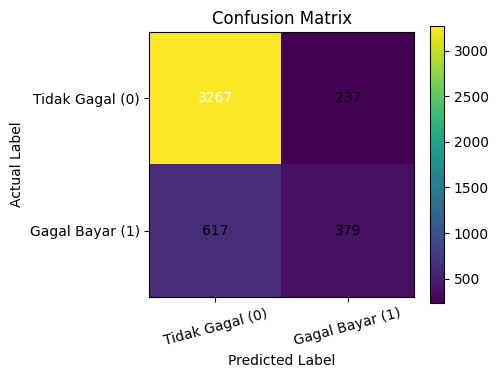

In [14]:
# ==========================================
# 9) EVALUASI MODEL
# ==========================================
# >>> PERBAIKAN: ravel() agar bentuknya 1D untuk sklearn
y_proba = model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("\nAccuracy:", acc)
print("F1-score:", f1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --- Confusion Matrix (grafik) ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Tidak Gagal (0)", "Gagal Bayar (1)"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=15)
plt.yticks(tick_marks, classes)

# Tampilkan angka di setiap kotak
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [12]:
# ==========================================
# 10) ANALISIS SINGKAT (lebih “nyata”)
# ==========================================
hist = pd.DataFrame(history.history)
best_epoch = int(hist["val_loss"].idxmin()) + 1
best_val_loss = hist["val_loss"].min()

print(f"\nAnalisis Singkat:")
print(f"- Epoch terbaik (val_loss minimum): {best_epoch} dengan val_loss = {best_val_loss:.4f}")
print("- Jika setelah epoch terbaik val_loss naik sementara train_loss turun → indikasi overfitting.")
print("- Jika train_loss & val_loss sama-sama tinggi → indikasi underfitting.")
print(f"- Hasil evaluasi test: Accuracy = {acc:.4f}, F1 = {f1:.4f}")


Analisis Singkat:
- Epoch terbaik (val_loss minimum): 22 dengan val_loss = 0.4370
- Jika setelah epoch terbaik val_loss naik sementara train_loss turun → indikasi overfitting.
- Jika train_loss & val_loss sama-sama tinggi → indikasi underfitting.
- Hasil evaluasi test: Accuracy = 0.8102, F1 = 0.4702


In [13]:
# ==========================================
# 11) SIMPAN MODEL & PREPROCESSOR (DEPLOYMENT READY)
# ==========================================
os.makedirs("artifacts", exist_ok=True)

# simpan preprocessing artifacts
joblib.dump(cat_imputer,      "artifacts/cat_imputer.joblib")
joblib.dump(num_imputer,      "artifacts/num_imputer.joblib")
joblib.dump(scaler,           "artifacts/scaler.joblib")

# simpan daftar kolom setelah one-hot (WAJIB untuk deploy)
joblib.dump(feature_columns,  "artifacts/feature_columns.joblib")

# simpan label encoder (opsional, tapi aman untuk disimpan)
joblib.dump(le,               "artifacts/label_encoder.joblib")

# simpan daftar kolom kategori & numerik (opsional tapi membantu app.py)
joblib.dump(categorical_cols, "artifacts/categorical_cols.joblib")
joblib.dump(numeric_cols,     "artifacts/numeric_cols.joblib")

# simpan model dengan nama yang dicari app.py
model.save("artifacts/ann_credit_default.keras")

print("\nSaved artifacts to artifacts/:")
print("- cat_imputer.joblib")
print("- num_imputer.joblib")
print("- scaler.joblib")
print("- feature_columns.joblib")
print("- label_encoder.joblib")
print("- categorical_cols.joblib")
print("- numeric_cols.joblib")
print("- ann_credit_default.keras")



Saved artifacts to artifacts/:
- cat_imputer.joblib
- num_imputer.joblib
- scaler.joblib
- feature_columns.joblib
- label_encoder.joblib
- categorical_cols.joblib
- numeric_cols.joblib
- ann_credit_default.keras
